### Aplicando Machine Learning sobre os dados
 - Carregando as bibliotecas para a nova etapa

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sp_houses_df = pd.read_csv("./dados/SaoPauloClean.csv").drop("Unnamed: 0", axis=1)

In [4]:
sp_houses_df.head()

,area_metro_quadrado_int,quartos_int,banheiros_int,vagas_int,preco_anuncio_float
0,1000,4,8,6,7000000.0
1,469,3,3,4,3700000.0
2,125,4,3,2,380000.0
3,310,3,2,4,685000.0
4,100,3,2,2,540000.0


## 5 - Produzindo o modelo de Regressão

### 5.1 - Analisando a matriz de correlação

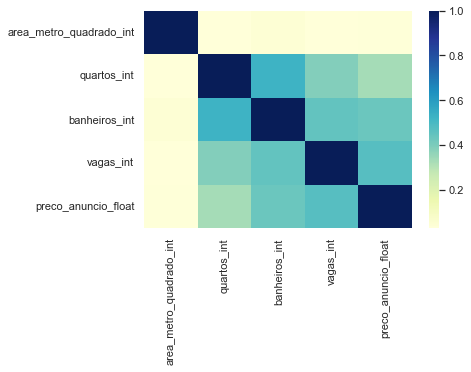

In [5]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(sp_houses_df.corr(method="pearson") ,cmap="YlGnBu")

- A respeito da seleção de features para uma regressão linear, é importante que as variáveis explicativas sejam colunas com pouca correlação entre si e que as variáveis explicativas e que tenham uma correlação significativa com a variável explicativa.
- Em se tratando do presente trabalho, as variáveis de área em m², numero de quartos, numero de banheiros e vagas de estacionamento serão escolhidas como explicativas.
- A variável de controle será o preço anunciado do imóvel.

### 5.2 - Analisando o histograma da variável de controle

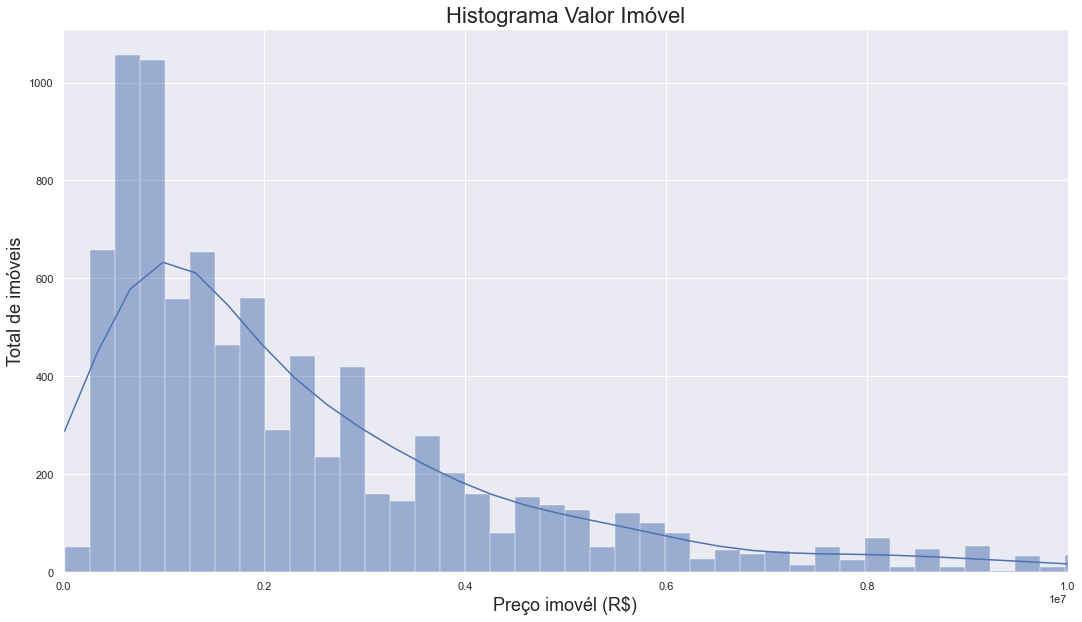

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(figsize=(18, 10))
ax = sns.histplot(data = sp_houses_df, x = "preco_anuncio_float", kde = True)
ax.set_title("Histograma Valor Imóvel", fontsize = 22)
ax.set_xlabel("Preço imovél (R$)", fontsize=18)
ax.set_ylabel("Total de imóveis", fontsize=18)
plt.xlim((-50, 10000000))
plt.show()

- Devido a assimetria que concentra o preço dos imóveis nas primeiras barras do histograma, as variáveis receberão uma transformação logarítmica para tentar normalizar os resultados e fazer previsões com maior precisão. 

In [7]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np. log1p, validate = True)
sp_houses_df_transformado = transformer.transform(sp_houses_df)
colunas_sp_house_df = sp_houses_df.columns
sp_houses_df_transformado = pd.DataFrame(sp_houses_df_transformado, columns=colunas_sp_house_df)
sp_houses_df_transformado.head()

,area_metro_quadrado_int,quartos_int,banheiros_int,vagas_int,preco_anuncio_float
0,6.908755,1.609438,2.197225,1.945910,15.761421
1,6.152733,1.386294,1.386294,1.609438,15.123844
2,4.836282,1.609438,1.386294,1.098612,12.847929
3,5.739793,1.386294,1.098612,1.609438,13.437176
4,4.615121,1.386294,1.098612,1.098612,13.199326


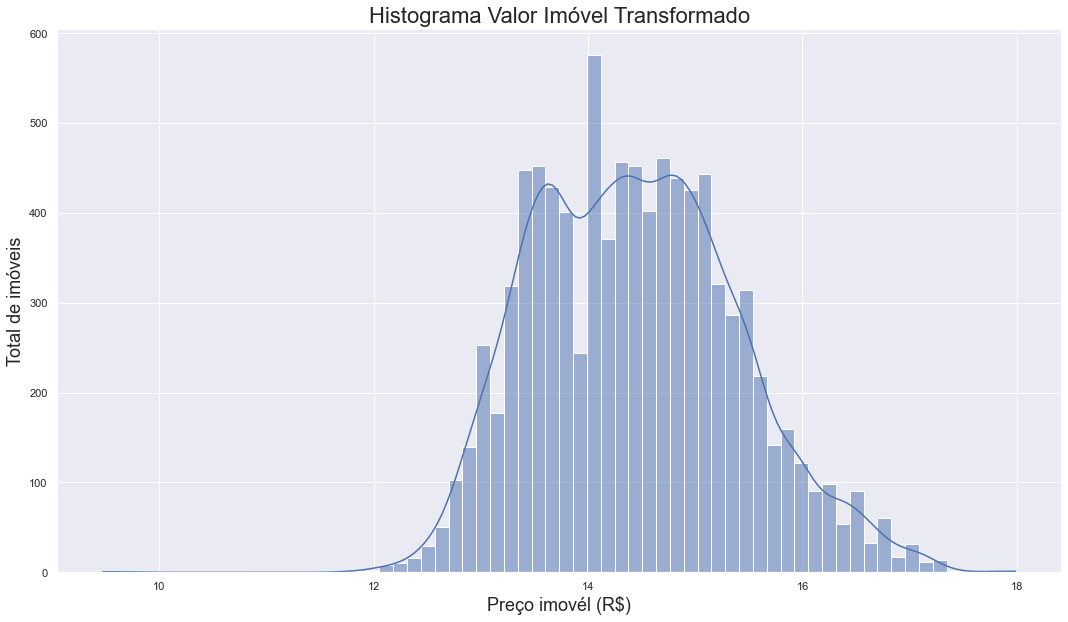

In [8]:
sns.set()
plt.figure(figsize=(18, 10))
ax = sns.histplot(data = sp_houses_df_transformado, x = "preco_anuncio_float", kde = True)
ax.set_title("Histograma Valor Imóvel Transformado", fontsize = 22)
ax.set_xlabel("Preço imovél (R$)", fontsize=18)
ax.set_ylabel("Total de imóveis", fontsize=18)
plt.show()

- Após a transformação logarítmica, a distribuição está mais próxima de uma distribuição simétrica.
- Com uma distribuição mais simétrica, as previsões serão feitas com maior precisão.

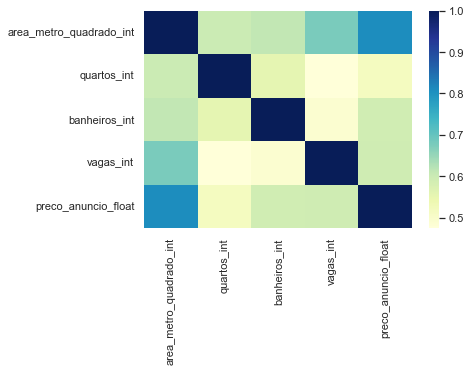

In [9]:
ax = sns.heatmap(sp_houses_df_transformado.corr(method="pearson") ,cmap="YlGnBu")

- Com a normalização também fica evidente a alta correlação entre preço do imóvel e a sua quantidade de metros quadrados disponível.

In [10]:
X = sp_houses_df_transformado[['area_metro_quadrado_int','quartos_int', 'banheiros_int', 'vagas_int']]

In [11]:
y = sp_houses_df_transformado['preco_anuncio_float']

In [12]:
resultados_modelos_df = pd.DataFrame()
resultados_modelos_dict = {
    "modelo": [],
    "R2": [],
    "MSE": [],
    "MSA": [],
    "media_cv": [],
    "intervalo_cv": []
}

### 5.3 - Separação entre dados de treino e dados de teste


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
X_train.head()

,area_metro_quadrado_int,quartos_int,banheiros_int,vagas_int
6304,5.564520,1.609438,1.386294,1.386294
5459,5.602119,1.386294,1.791759,1.791759
2300,6.115892,1.386294,1.609438,1.098612
5851,4.753590,1.098612,1.386294,1.098612
254,4.624973,1.386294,1.609438,1.098612


### 5.4 - Criando os modelos de Regressão

#### a) Dummy Regressor
- A ideia desse modelo será funcionar como um baseline para as análises, e à medida que outro modelos forem feitos, o baseline será atualizado.

In [16]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [17]:
def cv_stats (resultado_cv):
    media = resultado_cv['test_score'].mean()
    desvio_padrao = resultado_cv['test_score'].std()
    return media, [(media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100]

In [18]:
def imprime_resultado(r2, MSE, MSA, media_cv, intervalo_cv):
    print(f"R2: {r2_score_dummy:.4f}")
    print(f"MSE: {MSE_dummy:.4f}")
    print(f"MSA: {MSA_dummy:.4f}")
    print(f"Média CV: {media_cv:4f}")
    print(f"Intervalo CV: [{intervalo_cv[0]:.4f}, {intervalo_cv[1]:.4f}]")

In [19]:
from sklearn.dummy import DummyRegressor

In [20]:
# Dummy Regressor usando a estratégia de sempre chutar a mediana para a predição
modelo_dummy = DummyRegressor(strategy="median")

In [21]:
# Treinando o modelo com os dados de treino
modelo_dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [22]:
# Utilizando Cross Validate (cv)
cv = KFold(n_splits = 10, shuffle=True, random_state=42)
resultado_cv = cross_validate(modelo_dummy, X, y, cv = cv, return_train_score=False)

In [23]:
# Realizando a predicao
y_pred = modelo_dummy.predict(X_test)

In [24]:
# Métricas e resultados
r2_score_dummy = r2_score(y_test, y_pred)
MSE_dummy = mean_squared_error(y_test, y_pred)
MSA_dummy = mean_absolute_error(y_test, y_pred)
media_cv_dummy, intervalo_cv_dummy = cv_stats(resultado_cv)

imprime_resultado(r2_score_dummy, MSE_dummy, MSA_dummy, media_cv_dummy, intervalo_cv_dummy)

R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: -0.002026
Intervalo CV: [-0.4652, 0.0601]


- Observacoes importantes:
    - Para a métrica R2 (grau de ajuste das previsões aos dados reais), o valor ideal é 1 (modelo perfeito), e os piores modelos tem valores com valor 0 ou menor que 0 para o R2.
    - Para a métrica MSE (Erro Quadrático Médio), mede a média dos erros quadráticos sobre a diferença entre os valores estimados e os valores reais. Quanto mais próximo de 0.0, melhor é o modelo, e quanto mais distante, pior (maior erro).

In [25]:
resultados_modelos_dict["modelo"].append("Dummy")
resultados_modelos_dict["R2"].append(r2_score_dummy)
resultados_modelos_dict["MSE"].append(MSE_dummy)
resultados_modelos_dict["MSA"].append(MSA_dummy)
resultados_modelos_dict["media_cv"].append(media_cv_dummy)
resultados_modelos_dict["intervalo_cv"].append(f"[{intervalo_cv_dummy[0]:.4f}, {intervalo_cv_dummy[1]:.4f}]")

In [26]:
resultados_modelos_df = pd.DataFrame(resultados_modelos_dict).set_index("modelo")
resultados_modelos_df.head()

,R2,MSE,MSA,media_cv,intervalo_cv
modelo,,,,,
Dummy,-0.001048,0.886094,0.767022,-0.002026,"[-0.4652, 0.0601]"


#### b) Regressão Linear/ Polinomial
- Para problemas de regressão, a solução mais clássica é o uso de regressão linear. Porém, nem sempre os dados apresentam comportamento linear.
- Por conta disso, alguns modelos de regressão polinomal também serão avaliados (polinomial de 2ª a 4ª grau).

In [27]:
# Importando o modelo para regressão linear e polinomial
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [28]:
for i in range(1, 5):
    model_LR = LinearRegression()
    
    # Itera os graus dos polinômios, de 1ª a 5ª
    poly = PolynomialFeatures(i)
    
    # Treinando o modelo corrente com os dados de treino
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    model_LR.fit(X_train_poly, y_train)
    y_pred = model_LR.predict(X_test_poly)
    
    # Utilizando Cross Validate (cv)
    cv = KFold(n_splits = 10, shuffle=True, random_state=42)
    resultado_cv = cross_validate(model_LR, X, y, cv = cv, return_train_score=False)
    
    # Métricas e resultados
    r2_score_lr = r2_score(y_test, y_pred)
    MSE_lr = mean_squared_error(y_test, y_pred)
    MSA_lr = mean_absolute_error(y_test, y_pred)
    media_cv_lr, intervalo_cv_lr = cv_stats(resultado_cv)
    imprime_resultado(r2_score_lr, MSE_lr, MSA_lr, media_cv_lr, intervalo_cv_lr)
    
    # Adicionando resultados para análises posteriores
    resultados_modelos_dict["modelo"].append(f"Regressao grau {i}")
    resultados_modelos_dict["R2"].append(r2_score_lr)
    resultados_modelos_dict["MSE"].append(MSE_lr)
    resultados_modelos_dict["MSA"].append(MSA_lr)
    resultados_modelos_dict["media_cv"].append(media_cv_lr)
    resultados_modelos_dict["intervalo_cv"].append(f"[{intervalo_cv_lr[0]:.4f}, {intervalo_cv_lr[1]:.4f}]")
    resultados_modelos_df = pd.DataFrame(resultados_modelos_dict).set_index("modelo")

R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.667432
Intervalo CV: [61.7446, 71.7419]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.667432
Intervalo CV: [61.7446, 71.7419]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.667432
Intervalo CV: [61.7446, 71.7419]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.667432
Intervalo CV: [61.7446, 71.7419]


In [29]:
resultados_modelos_df

,R2,MSE,MSA,media_cv,intervalo_cv
modelo,,,,,
Dummy,-0.001048,0.886094,0.767022,-0.002026,"[-0.4652, 0.0601]"
Regressao grau 1,0.668827,0.293144,0.410012,0.667432,"[61.7446, 71.7419]"
Regressao grau 2,0.672947,0.289497,0.407328,0.667432,"[61.7446, 71.7419]"
Regressao grau 3,0.633021,0.324838,0.406381,0.667432,"[61.7446, 71.7419]"
Regressao grau 4,0.190064,0.716928,0.422995,0.667432,"[61.7446, 71.7419]"


 - O modelo de regressao linear/ polinomial superou o baseline.
 - Outro fator importante é que a regressão polinomial de grau se destacou como a melhor taxa de ajuste aos dados (R²) e com o menor erro quadrático médio (MSE), embora com valores próximos ao da regressão linear (grau 1). 

#### c) Decision Tree Regressor: Árvore de Decisao
- Para o modelo de regressão usando árvores de decisão, serão usadas 5 e 10 níveis (depth) para avaliar o desempenho dessa técnica.

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
for i in range(1, 3):
    
    # Treinando o modelo corrente com os dados de treino
    modelo_dtr = DecisionTreeRegressor(random_state=42, max_depth = 5 * i)
    modelo_dtr.fit(X_train, y_train)
    y_pred = modelo_dtr.predict(X_test)
        
    # Utilizando Cross Validate (cv)
    cv = KFold(n_splits = 10, shuffle=True, random_state=42)
    resultado_cv = cross_validate(modelo_dtr, X, y, cv = cv, return_train_score=False)
    
    # Métricas e resultados
    r2_score_dtr = r2_score(y_test, y_pred)
    MSE_dtr = mean_squared_error(y_test, y_pred)
    MSA_dtr = mean_absolute_error(y_test, y_pred)
    media_cv_dtr, intervalo_cv_dtr = cv_stats(resultado_cv)
    imprime_resultado(r2_score_dtr, MSE_dtr, MSA_dtr, media_cv_dtr, intervalo_cv_dtr)
    
    # Adicionando resultados para análises posteriores
    resultados_modelos_dict["modelo"].append(f"Decision Tree (depth={5 * i})")
    resultados_modelos_dict["R2"].append(r2_score_dtr)
    resultados_modelos_dict["MSE"].append(MSE_dtr)
    resultados_modelos_dict["MSA"].append(MSA_dtr)
    resultados_modelos_dict["media_cv"].append(media_cv_dtr)
    resultados_modelos_dict["intervalo_cv"].append(f"[{intervalo_cv_dtr[0]:.4f}, {intervalo_cv_dtr[1]:.4f}]")
    resultados_modelos_df = pd.DataFrame(resultados_modelos_dict).set_index("modelo")

R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.676848
Intervalo CV: [64.1467, 71.2230]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.684414
Intervalo CV: [62.7645, 74.1184]


In [32]:
resultados_modelos_df

,R2,MSE,MSA,media_cv,intervalo_cv
modelo,,,,,
Dummy,-0.001048,0.886094,0.767022,-0.002026,"[-0.4652, 0.0601]"
Regressao grau 1,0.668827,0.293144,0.410012,0.667432,"[61.7446, 71.7419]"
Regressao grau 2,0.672947,0.289497,0.407328,0.667432,"[61.7446, 71.7419]"
Regressao grau 3,0.633021,0.324838,0.406381,0.667432,"[61.7446, 71.7419]"
Regressao grau 4,0.190064,0.716928,0.422995,0.667432,"[61.7446, 71.7419]"
Decision Tree (depth=5),0.688423,0.275797,0.409847,0.676848,"[64.1467, 71.2230]"
Decision Tree (depth=10),0.684988,0.278838,0.399057,0.684414,"[62.7645, 74.1184]"


#### d) Random Forest Regressor: Floresta Aleatória
- Para o modelo de Regressão baseado em Floresta Aleatória, serão utilizados 100 estimadores por padrão e o nível máximo de cada árvore será 5, 10, 15 e 20.

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
for i in range(1, 5):
    
    # Treinando o modelo corrente com os dados de treino
    modelo_rfr = RandomForestRegressor(n_estimators=100, max_depth=5 * i, random_state=42)
    modelo_rfr.fit(X_train, y_train)
    y_pred = modelo_rfr.predict(X_test)
    
    # Utilizando Cross Validate (cv)
    cv = KFold(n_splits = 10, shuffle=True, random_state=42)
    resultado_cv = cross_validate(modelo_rfr, X, y, cv = cv, return_train_score=False)
    
    
    # Métricas e resultados
    r2_score_rfr = r2_score(y_test, y_pred)
    MSE_rfr = mean_squared_error(y_test, y_pred)
    MSA_rfr = mean_absolute_error(y_test, y_pred)
    media_cv_rfr, intervalo_cv_rfr = cv_stats(resultado_cv)
    imprime_resultado(r2_score_rfr, MSE_rfr, MSA_rfr, media_cv_rfr, intervalo_cv_rfr)
    
    # Adicionando resultados para análises posteriores
    resultados_modelos_dict["modelo"].append(f"Random Forest (depth={5 * i}, n_estimators=100)")
    resultados_modelos_dict["R2"].append(r2_score_rfr)
    resultados_modelos_dict["MSE"].append(MSE_rfr)
    resultados_modelos_dict["MSA"].append(MSA_rfr)
    resultados_modelos_dict["media_cv"].append(media_cv_rfr)
    resultados_modelos_dict["intervalo_cv"].append(f"[{intervalo_cv_rfr[0]:.4f}, {intervalo_cv_rfr[1]:.4f}]")
    resultados_modelos_df = pd.DataFrame(resultados_modelos_dict).set_index("modelo")

R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.689551
Intervalo CV: [64.8861, 73.0241]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.729265
Intervalo CV: [68.8328, 77.0202]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.754516
Intervalo CV: [70.8857, 80.0175]
R2: -0.0010
MSE: 0.8861
MSA: 0.7670
Média CV: 0.753305
Intervalo CV: [70.4168, 80.2442]


In [35]:
resultados_modelos_df

,R2,MSE,MSA,media_cv,intervalo_cv
modelo,,,,,
Dummy,-0.001048,0.886094,0.767022,-0.002026,"[-0.4652, 0.0601]"
Regressao grau 1,0.668827,0.293144,0.410012,0.667432,"[61.7446, 71.7419]"
Regressao grau 2,0.672947,0.289497,0.407328,0.667432,"[61.7446, 71.7419]"
Regressao grau 3,0.633021,0.324838,0.406381,0.667432,"[61.7446, 71.7419]"
Regressao grau 4,0.190064,0.716928,0.422995,0.667432,"[61.7446, 71.7419]"
Decision Tree (depth=5),0.688423,0.275797,0.409847,0.676848,"[64.1467, 71.2230]"
Decision Tree (depth=10),0.684988,0.278838,0.399057,0.684414,"[62.7645, 74.1184]"
"Random Forest (depth=5, n_estimators=100)",0.705993,0.260245,0.399486,0.689551,"[64.8861, 73.0241]"
"Random Forest (depth=10, n_estimators=100)",0.739192,0.230858,0.374197,0.729265,"[68.8328, 77.0202]"


 - Pelo que pode-se notar da tabela com os resultados dos desempenhos de cada modelo, o modelo de Random Forest com 15 de profundidade e 100 estimadores é o mais preciso, uma vez que ela atingiu o maior R2, o menor MSE, o segundo menor MSA, a melhor e intervalo mais consistente de validação cruzada.
 - Vale ressaltar que o desempenho médio do modelo de floresta aleatória superou os demais modelos.
 - O modelo "Random Forest" será o escolhido para a otimização com hiperparâmetros! 

### 5.5 - Otimizando o modelo de Random Forest com hiperparâmetros

In [124]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RandomizedSearchCV

In [125]:
#definindo o K - número de subconjuntos
cv = KFold(n_splits = 5, shuffle=True)

In [126]:
desempenhoRF_cross_val_r2 = cross_val_score(estimator = modelo_rfr,
                                       X = X_train, 
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Desempenho médio de r2: {}'.format(round(desempenhoRF_cross_val_r2.mean(), 3)))

Desempenho médio de r2: 0.714


In [127]:
param_random_rf = {
    'criterion': ["squared_error", "absolute_error", "poisson"],
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [15, 17, 19, 20],
    'min_samples_split': [1, 3, 5, 7, 9, 11],
    'min_samples_leaf': [1, 5, 10, 15, 20]
}

In [128]:
random_cv_rf = RandomizedSearchCV(
    modelo_rfr, 
    param_random_rf, 
    n_iter=100, 
    cv=cv, 
    scoring='r2',
    n_jobs=-1,
    random_state = 42
)

In [129]:
rf_randomcv = random_cv_rf.fit(X_train, y_train)

In [130]:
pd.DataFrame(rf_randomcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043493,0.002985,0.000000,0.000000,25,1,10,17,squared_error,"{'n_estimators': 25, 'min_samples_split': 1, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
1,38.411541,0.372252,0.054944,0.007893,50,3,1,17,absolute_error,"{'n_estimators': 50, 'min_samples_split': 3, '...",0.667410,0.734960,0.725862,0.708837,0.734589,0.714332,0.025301,2
2,16.707454,0.281759,0.021905,0.002810,25,11,10,15,absolute_error,"{'n_estimators': 25, 'min_samples_split': 11, ...",0.642046,0.709425,0.696773,0.675052,0.704227,0.685505,0.024688,50
3,0.808387,0.007672,0.038603,0.001897,50,9,10,15,squared_error,"{'n_estimators': 50, 'min_samples_split': 9, '...",0.652380,0.712975,0.706173,0.688720,0.712884,0.694626,0.022904,24
4,17.278913,0.235417,0.022864,0.004378,25,3,5,17,absolute_error,"{'n_estimators': 25, 'min_samples_split': 3, '...",0.648930,0.714027,0.706326,0.683911,0.706579,0.691955,0.023763,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.114557,0.010070,0.000000,0.000000,100,1,10,20,squared_error,"{'n_estimators': 100, 'min_samples_split': 1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
96,0.719981,0.042447,0.036128,0.003474,50,3,10,20,squared_error,"{'n_estimators': 50, 'min_samples_split': 3, '...",0.652378,0.712936,0.706189,0.688704,0.712847,0.694611,0.022895,26
97,1.521897,0.086100,0.032090,0.007564,50,9,1,19,poisson,"{'n_estimators': 50, 'min_samples_split': 9, '...",0.328706,0.419161,0.456549,0.401927,0.331177,0.387504,0.050214,80
98,0.033764,0.005513,0.000000,0.000000,25,1,15,15,poisson,"{'n_estimators': 25, 'min_samples_split': 1, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,95


In [131]:
rf_randomcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'criterion': 'absolute_error'}

In [132]:
rf_randomcv.best_score_

0.7143355139948764

#### Modelo com os parâmetros otimizados

In [133]:
rf_otimizado2 = RandomForestRegressor(random_state=42,
                                      n_estimators=100,
                                     min_samples_split= 3,
                                     min_samples_leaf=1,
                                     max_depth = 20,
                                     criterion = 'absolute_error')

In [134]:
rf_otimizado2.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      min_samples_split=3, random_state=42)

In [135]:
predicao_rf_otimizado2 = rf_otimizado2.predict(X_test)

In [136]:
r2_score(y_test, predicao_rf_otimizado2)

0.7488487288292761

In [ ]:
# best

In [107]:
rf_otimizado_best = RandomForestRegressor(random_state=42,
                                      n_estimators=100,
                                     # min_samples_split= 2,
                                     # min_samples_leaf=1,
                                     max_depth = 15,
                                     criterion = 'squared_error')

In [108]:
rf_otimizado_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=42)

In [109]:
predicao_rf_otimizado_best = rf_otimizado_best.predict(X_test)

In [110]:
r2_score(y_test, predicao_rf_otimizado_best)

0.751706332183583